--- Training EagerPatterns LAD Classifier (with Greedy Set Cover) ---

--- EagerPatterns (Greedy) Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.98      0.92        43
           1       0.98      0.92      0.95        71

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.94      0.94      0.94       114


--- EagerPatterns (Greedy) Rule List ---
EagerPatterns Rule List:
[Class 0]
 - IF mean radius > 13.290000 AND worst texture > 20.225000 AND worst perimeter > 91.695000 AND worst perimeter > 105.950000 AND worst perimeter > 120.350000 THEN class=0 (conf=1.00, supp=0.25)
 - IF mean radius > 13.290000 AND mean texture > 16.690000 AND worst perimeter > 91.695000 AND worst perimeter > 105.950000 AND worst perimeter > 120.350000 THEN class=0 (conf=1.00, supp=0.25)
 - IF mean texture > 16.690000 AND mean texture > 19.485000 AND perimeter error > 1.9

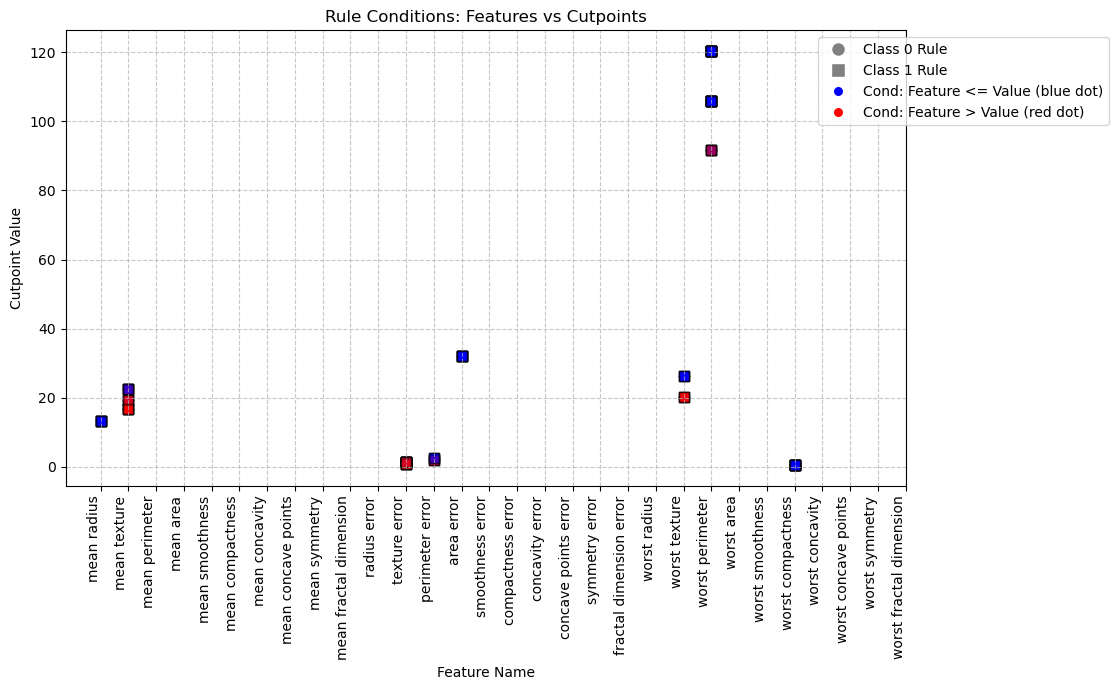

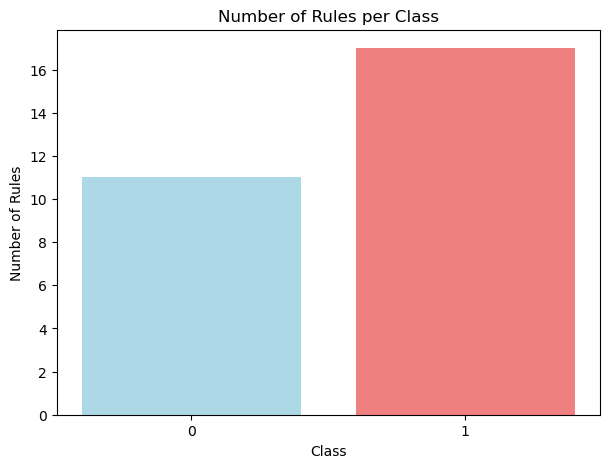

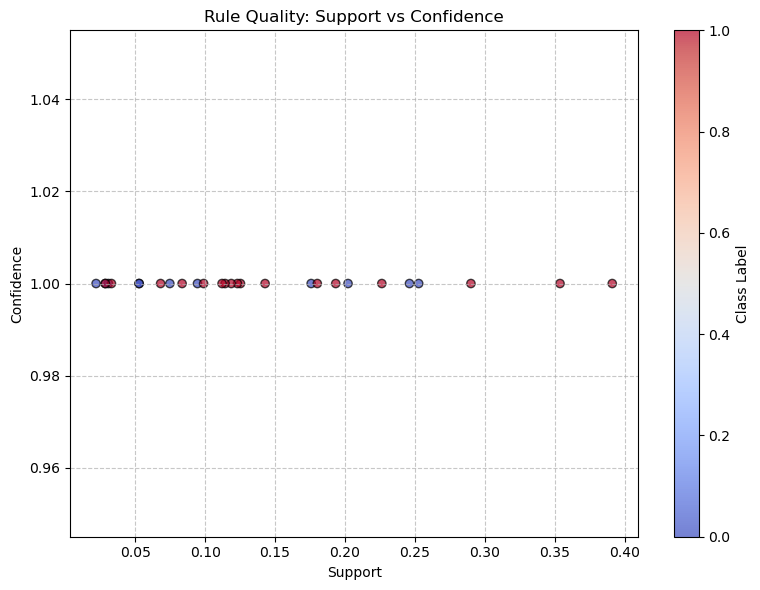

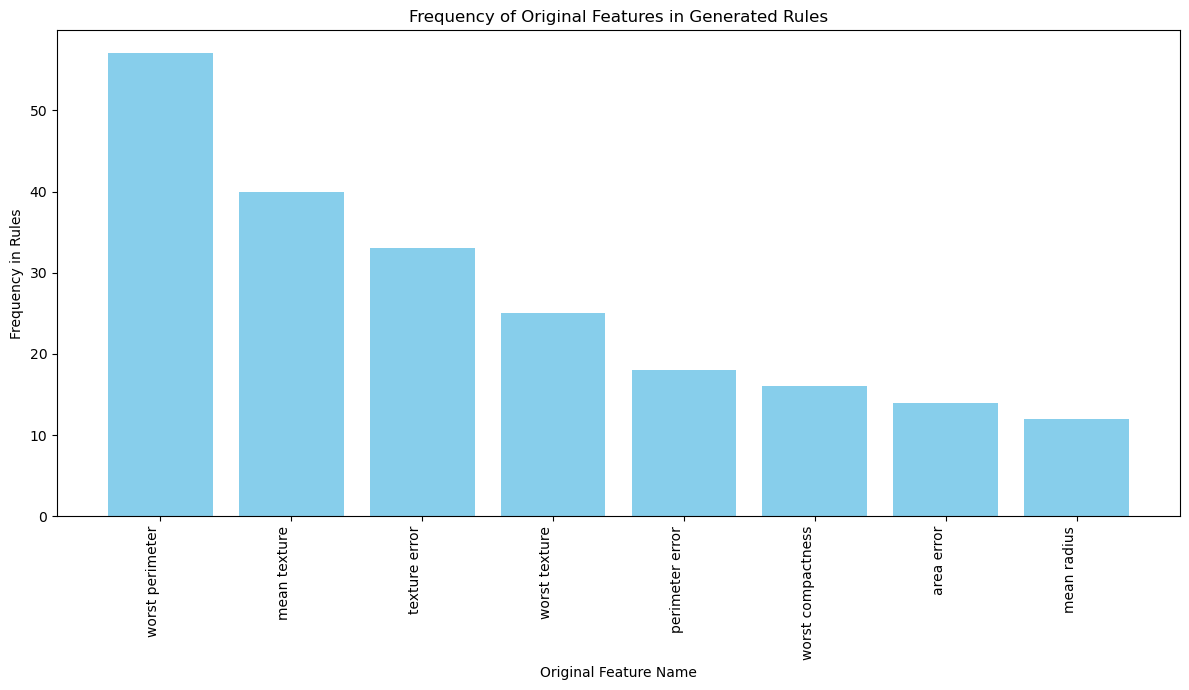

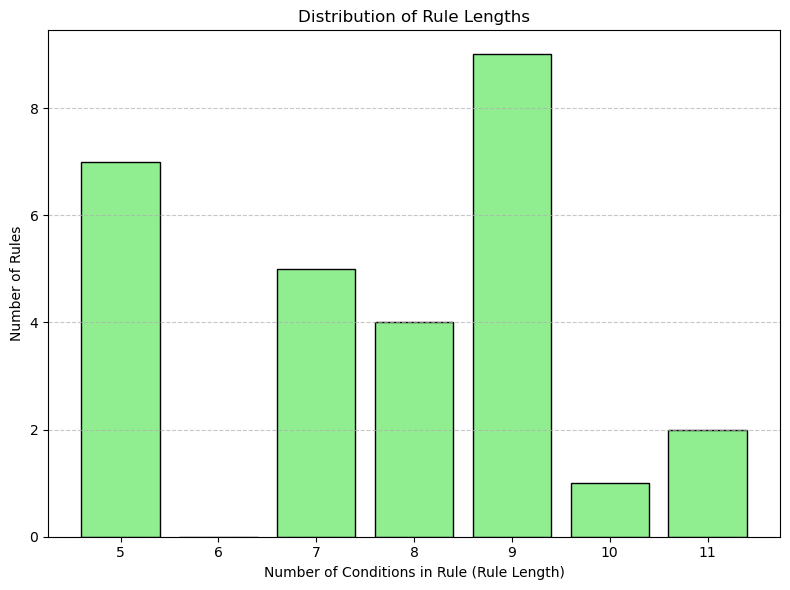

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import json
# PuLP import는 제거되었습니다.

class CutpointBinarizer():
    """
    Converts continuous data to binary data by finding optimal cutpoints.
    연속형 데이터를 최적의 절단점을 찾아 이진 데이터로 변환합니다.
    """
    def __init__(self, tolerance=0.0):
        self.__tolerance = tolerance
        self.__cutpoints = {} # {절단점_id: (원본_특성_인덱스, 절단값)} 형태로 저장
        self.__cutpoint_order = [] # 생성된 순서대로 절단점_id 저장

    def get_cutpoints(self):
        return self.__cutpoints

    def get_cutpoint_order(self):
        return self.__cutpoint_order

    def fit(self, X, y):
        self.__cutpoints.clear()
        self.__cutpoint_order = []

        att = -1
        for col_data in X.T: # 열(특성) 반복
            att += 1
            labels_prev = None 
            u_prev = None  
            
            sorted_unique_vals = sorted(np.unique(col_data))
            
            if not sorted_unique_vals: # 특성에 고유값이 없으면 건너뜀
                continue

            for v_curr in sorted_unique_vals:
                if u_prev is None:
                    u_prev = v_curr
                    labels_prev = set(y[np.where(col_data == v_curr)[0]])
                    continue

                variation = v_curr - u_prev
                current_indices = np.where(col_data == v_curr)[0]
                labels_curr = set(y[current_indices])

                if labels_prev is not None and variation > self.__tolerance:
                    # 클래스 레이블이 변경되거나 혼합된 경우 절단점 생성
                    if (len(labels_prev) > 1 or len(labels_curr) > 1) or labels_prev != labels_curr:
                        cid = len(self.__cutpoints) 
                        self.__cutpoints[cid] = (att, u_prev + variation / 2.0)
                        self.__cutpoint_order.append(cid)
                
                labels_prev = labels_curr
                u_prev = v_curr
        return self

    def transform(self, X):
        if not self.__cutpoints: # 학습된 절단점이 없는 경우
             return np.empty((X.shape[0], 0), dtype=bool)

        Xbin = np.empty((X.shape[0], 0), bool)

        # fit에서 설정된 절단점 순서대로 변환
        for cid in self.__cutpoint_order:
            att, cutpoint_val = self.__cutpoints[cid]
            
            if att >= X.shape[1]: 
                continue
            
            # 이진화: 값이 절단점 이하이면 True, 아니면 False
            # hstack을 위해 열 벡터로 reshape
            col_to_binarize = X[:, att]
            binarized_col = (col_to_binarize <= cutpoint_val).reshape(X.shape[0], 1)
            Xbin = np.hstack((Xbin, binarized_col))
        
        return Xbin

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

class UnWeightedSetCoveringProblem():
    """
    Set Covering Problem (SCP) 인스턴스 빌더.
    행은 서로 다른 클래스의 샘플 쌍이고, 열은 이진 특성인 행렬을 생성합니다.
    특성이 해당 쌍을 구분하면 항목은 1이 됩니다.
    """
    def __init__(self):
        self.__scp = np.array([]) # 빈 numpy 배열로 초기화

    def fit(self, Xbin, y):
        self.__scp = [] # 각 fit마다 초기화
        labels = np.unique(y)
        
        # 비교할 클래스가 2개 이상 있는지 확인
        if len(labels) < 2:
            self.__scp = np.empty((0, Xbin.shape[1]), dtype=bool) # 커버할 쌍 없음
            return self.__scp

        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                # 클래스 i와 클래스 j의 샘플 가져오기
                samples_class_i = Xbin[y == labels[i]]
                samples_class_j = Xbin[y == labels[j]]

                if samples_class_i.shape[0] == 0 or samples_class_j.shape[0] == 0:
                    continue

                for u_sample_class_i in samples_class_i:
                    for v_sample_class_j in samples_class_j:
                        # XOR는 특성 값이 다른 경우 True(1)가 됨
                        self.__scp.append(np.bitwise_xor(u_sample_class_i, v_sample_class_j))
        
        if not self.__scp: # 구분되는 쌍을 찾지 못한 경우
            self.__scp = np.empty((0, Xbin.shape[1]), dtype=bool)
        else:
            self.__scp = np.array(self.__scp, dtype=bool)
            
        return self.__scp

class EfficientGreedySetCover():
    """
    Efficient Greedy Set Cover solver.
    Selects a subset of features (columns from SCP matrix) that covers all elements (rows).
    효율적인 Greedy Set Cover 해결기.
    모든 요소(행)를 커버하는 특성(SCP 행렬의 열)의 부분 집합을 선택합니다.
    """
    def __init__(self):
        self.__selected_sets_indices = [] # Indices of selected binary features (columns of Xbin)
        self.scp_builder = UnWeightedSetCoveringProblem()

    def get_selected(self):
        return np.array(sorted(self.__selected_sets_indices), dtype=int)

    def fit(self, Xbin, y): # Xbin: binarized data, y: labels
        self.__selected_sets_indices = []

        scp_matrix = self.scp_builder.fit(Xbin, y)
        
        if scp_matrix.size == 0: 
            return self

        num_elements_to_cover, num_potential_sets = scp_matrix.shape

        if num_elements_to_cover == 0 or num_potential_sets == 0: 
            return self

        elements_covered_mask = np.zeros(num_elements_to_cover, dtype=bool) # Initially all False
        num_elements_left_to_cover = num_elements_to_cover
        
        available_sets_mask = np.ones(num_potential_sets, dtype=bool)

        while num_elements_left_to_cover > 0:
            current_available_set_indices = np.where(available_sets_mask)[0]

            if not current_available_set_indices.size:
                break 
            
            if np.sum(~elements_covered_mask) == 0: # All elements covered
                break

            # Consider only elements not yet covered for calculating coverage counts
            sub_scp_for_coverage_count = scp_matrix[~elements_covered_mask, :][:, current_available_set_indices]
            
            if sub_scp_for_coverage_count.shape[0] == 0: 
                 break

            coverage_counts = sub_scp_for_coverage_count.sum(axis=0)
            
            if not coverage_counts.size or np.all(coverage_counts == 0):
                break 
            
            best_set_local_idx = np.argmax(coverage_counts)
            
            if coverage_counts[best_set_local_idx] == 0: 
                break
                
            best_set_global_idx = current_available_set_indices[best_set_local_idx]
            self.__selected_sets_indices.append(best_set_global_idx)
            
            # Update elements_covered_mask
            # Elements covered by the chosen set (among those not yet covered)
            elements_newly_covered_by_chosen_set_in_scp = scp_matrix[:, best_set_global_idx].astype(bool)
            elements_covered_mask = elements_covered_mask | elements_newly_covered_by_chosen_set_in_scp
            num_elements_left_to_cover = num_elements_to_cover - np.sum(elements_covered_mask) # Re-calculate based on the whole mask
            
            available_sets_mask[best_set_global_idx] = False
        return self
            
    def transform(self, Xbin): 
        if not self.__selected_sets_indices:
            return np.empty((Xbin.shape[0], 0), dtype=Xbin.dtype)
        
        if Xbin.ndim == 1:
            raise ValueError("Xbin input to transform must be 2-dimensional.")
            
        return Xbin[:, sorted(self.__selected_sets_indices)]

    def fit_transform(self, Xbin, y): 
        self.fit(Xbin, y)
        return self.transform(Xbin)

class EagerPatterns:
    """
    Eager 학습 패턴 기반 분류기.
    규칙은 fit 단계에서 생성됩니다.
    """
    def __init__(self, binarizer, selector, min_conf=0.7, min_supp=0.01):
        self.__rules = [] 
        self.__binarizer = binarizer 
        self.__selector = selector   
        self.__min_conf = min_conf
        self.__min_supp = min_supp
        
        self.__labels = []
        self.__cutpoints_map = {} 
        self.__selected_cutpoint_info = [] 

    def fit(self, Xbin_selected, y): 
        self.__labels = np.unique(y)
        self.__Xbin_fitted = Xbin_selected 
        self.__y_fitted = y             

        self.__cutpoints_map = self.__binarizer.get_cutpoints()
        original_cutpoint_order = self.__binarizer.get_cutpoint_order()
        selected_gsc_indices = self.__selector.get_selected() 

        self.__selected_cutpoint_info = [] 
        for gsc_idx in selected_gsc_indices:
            if 0 <= gsc_idx < len(original_cutpoint_order):
                 cid = original_cutpoint_order[gsc_idx]
                 self.__selected_cutpoint_info.append(self.__cutpoints_map[cid])

        self.__rules = [] 
        for l_target_class in self.__labels:
            class_samples_mask = (y == l_target_class)
            Xbin_class_samples = Xbin_selected[class_samples_mask]
            
            if Xbin_class_samples.shape[0] == 0: continue 

            for instance_selected_bin in Xbin_class_samples: 
                current_rule_attributes_indices = list(np.arange(instance_selected_bin.shape[0])) 
                
                _, current_confidence, current_support, current_lift = self.__get_stats(
                    instance_selected_bin, current_rule_attributes_indices, l_target_class)

                while len(current_rule_attributes_indices) > 1:
                    best_attr_to_remove_idx_in_list = -1 
                    best_resulting_confidence = current_confidence
                    best_resulting_support = current_support
                    
                    temp_attributes_indices_for_pruning = list(current_rule_attributes_indices)

                    for i, attr_idx_in_selected_bin in enumerate(current_rule_attributes_indices):
                        temp_attributes_indices_for_pruning.pop(i) 
                        
                        if not temp_attributes_indices_for_pruning:
                            temp_attributes_indices_for_pruning.insert(i, attr_idx_in_selected_bin)
                            continue

                        _, temp_confidence, temp_support, _ = self.__get_stats(
                            instance_selected_bin, temp_attributes_indices_for_pruning, l_target_class)
                        
                        if temp_confidence > best_resulting_confidence or \
                           (temp_confidence == best_resulting_confidence and temp_support > best_resulting_support):
                            best_attr_to_remove_idx_in_list = i
                            best_resulting_confidence = temp_confidence
                            best_resulting_support = temp_support
                        
                        temp_attributes_indices_for_pruning.insert(i, attr_idx_in_selected_bin)

                    if best_attr_to_remove_idx_in_list != -1:
                        current_rule_attributes_indices.pop(best_attr_to_remove_idx_in_list)
                        current_confidence = best_resulting_confidence
                        current_support = best_resulting_support
                    else:
                        break 
                
                final_label, final_confidence, final_support, final_lift = self.__get_stats(
                    instance_selected_bin, current_rule_attributes_indices, l_target_class)

                if final_confidence >= self.__min_conf and final_support >= self.__min_supp and final_label == l_target_class:
                    rule_orig_feat_indices = []
                    rule_binary_conditions = [] 
                    rule_cut_values = []

                    for idx_in_selected in current_rule_attributes_indices:
                        if 0 <= idx_in_selected < len(self.__selected_cutpoint_info):
                            orig_feat_idx, cut_val = self.__selected_cutpoint_info[idx_in_selected]
                            rule_orig_feat_indices.append(orig_feat_idx)
                            rule_binary_conditions.append(bool(instance_selected_bin[idx_in_selected]))
                            rule_cut_values.append(cut_val)

                    new_rule = {
                        'label': final_label,
                        'attributes': rule_orig_feat_indices, 
                        'conditions': rule_binary_conditions, 
                        'values': rule_cut_values,         
                        'confidence': final_confidence,
                        'support': final_support,
                        'lift': final_lift
                    }
                    if new_rule not in self.__rules: 
                        self.__rules.append(new_rule)
        
        self.__rules.sort(key=lambda r: (r['label'], -r['confidence'], -r['support'], -r['lift']))
        self._adjust_rules_for_duplicates() 
        return self

    def _adjust_rules_for_duplicates(self):
        unique_rules_dict = {}
        for r in self.__rules:
            antecedent_parts = []
            for i in range(len(r['attributes'])):
                antecedent_parts.append((r['attributes'][i], r['conditions'][i], round(r['values'][i], 6))) 
            
            antecedent_key = tuple(sorted(antecedent_parts))
            rule_key = (r['label'], antecedent_key)

            if rule_key not in unique_rules_dict:
                unique_rules_dict[rule_key] = r
            else:
                existing_rule = unique_rules_dict[rule_key]
                if r['confidence'] > existing_rule['confidence'] or \
                   (r['confidence'] == existing_rule['confidence'] and r['support'] > existing_rule['support']) or \
                   (r['confidence'] == existing_rule['confidence'] and r['support'] == existing_rule['support'] and r['lift'] > existing_rule['lift']):
                    unique_rules_dict[rule_key] = r
        
        self.__rules = sorted(unique_rules_dict.values(), key=lambda r: (r['label'], -r['confidence'], -r['support'], -r['lift']))

    def predict(self, X_orig): 
        predictions = []
        for i in range(X_orig.shape[0]): 
            scores_for_sample_per_class = {l: 0.0 for l in self.__labels} 
            
            for r in self.__rules:
                rule_matches_sample = True
                for j in range(len(r['attributes'])): 
                    original_feature_index = r['attributes'][j]
                    binary_condition_true_for_le = r['conditions'][j] 
                    cutpoint_value_for_rule = r['values'][j]
                    
                    sample_feature_value = X_orig[i, original_feature_index]

                    if binary_condition_true_for_le: 
                        if not (sample_feature_value <= cutpoint_value_for_rule):
                            rule_matches_sample = False
                            break 
                    else: 
                        if not (sample_feature_value > cutpoint_value_for_rule):
                            rule_matches_sample = False
                            break
                
                if rule_matches_sample:
                    scores_for_sample_per_class[r['label']] += r['confidence'] * r['support'] 
            
            if not any(scores_for_sample_per_class.values()): 
                predicted_label = self.__labels[0] if len(self.__labels) > 0 else 0
            else:
                predicted_label = max(scores_for_sample_per_class.items(), key=lambda x: x[1])[0]
            
            predictions.append(predicted_label)
        return np.array(predictions)

    def predict_proba(self, X_orig):
        preds = self.predict(X_orig)
        n_classes = len(self.__labels)
        proba = np.zeros((len(preds), n_classes if n_classes > 0 else 1))
        
        if n_classes == 0: return proba

        for i, p_val in enumerate(preds):
            label_idx = np.where(self.__labels == p_val)[0]
            if label_idx.size > 0:
                proba[i][label_idx[0]] = 1.0
        return proba

    def __get_stats(self, instance_selected_bin, attributes_indices_in_selected, target_label):
        rule_conditions_mask = (self.__Xbin_fitted[:, attributes_indices_in_selected] == instance_selected_bin[attributes_indices_in_selected])
        
        covered_samples_mask = np.all(rule_conditions_mask, axis=1)
        covered_indices = np.where(covered_samples_mask)[0]

        confidence = 0
        support = 0
        lift = 1.0 

        if len(covered_indices) > 0:
            labels_of_covered_samples = self.__y_fitted[covered_indices]
            unique_labels_covered, counts_labels_covered = np.unique(labels_of_covered_samples, return_counts=True)
            
            if target_label in unique_labels_covered:
                target_label_idx_in_unique = np.where(unique_labels_covered == target_label)[0][0]
                
                confidence = counts_labels_covered[target_label_idx_in_unique] / np.sum(counts_labels_covered)
                support = counts_labels_covered[target_label_idx_in_unique] / self.__Xbin_fitted.shape[0] 
                
                proportion_target_label_in_dataset = np.mean(self.__y_fitted == target_label)
                if proportion_target_label_in_dataset > 1e-9: 
                    lift = confidence / proportion_target_label_in_dataset
                elif confidence > 0: 
                    lift = float('inf')
        return target_label, confidence, support, lift

    def __str__(self):
        s = 'EagerPatterns Rule List:\n'
        grouped = defaultdict(list)
        for r in self.__rules: 
            grouped[r['label']].append(r)

        for label_class in sorted(grouped.keys()): 
            s += f'[Class {label_class}]\n'
            for r in grouped[label_class]:
                conditions_str_list = []
                for i in range(len(r['attributes'])):
                    original_feature_index = r['attributes'][i]
                    binary_condition_true_for_le = r['conditions'][i]
                    cutpoint_value = r['values'][i]
                    
                    feat_name = self.__feature_names[original_feature_index] if hasattr(self, '_EagerPatterns__feature_names') and original_feature_index < len(self.__feature_names) else f'att{original_feature_index}'
                    
                    op_str = "<=" if binary_condition_true_for_le else ">"
                    conditions_str_list.append(f'{feat_name} {op_str} {cutpoint_value:.6f}')
                
                s += f" - IF {' AND '.join(conditions_str_list)} THEN class={r['label']} (conf={r['confidence']:.2f}, supp={r['support']:.2f})\n" 
        if not self.__rules:
            s += " (No rules generated)\n"
        return s

    def set_feature_names(self, feature_names):
        self.__feature_names = feature_names
    
    def save_rules(self, filepath):
        def convert_numpy_types(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            if isinstance(obj, np.bool_):
                return bool(obj)
            return obj
        
        with open(filepath, 'w') as f:
            json.dump(self.__rules, f, indent=2, default=convert_numpy_types)

class LADClassifier(BaseEstimator, ClassifierMixin):
    """
    LAD (Logical Analysis of Data) Classifier.
    Only 'eager' mode is supported.
    """
    def __init__(self, tolerance=0.001, purity=0.95, 
                 eager_min_conf=0.7, eager_min_supp=0.01 
                ):
        self.tolerance = tolerance
        self.purity = purity 
        self.mode = "eager" # Mode is fixed to eager

        self.eager_min_conf = eager_min_conf
        self.eager_min_supp = eager_min_supp

        self.model_ = None 
        self.cpb_ = CutpointBinarizer(self.tolerance)
        self.gsc_ = EfficientGreedySetCover() # Greedy solver will be used here
        self._feature_names_in = None 

    def fit(self, X, y, feature_names=None): 
        X_orig, y_orig = check_X_y(X, y, accept_sparse=True)
        self.is_fitted_ = True
        
        if feature_names is not None:
            self._feature_names_in = feature_names
        elif hasattr(X_orig, 'columns'): 
            self._feature_names_in = X_orig.columns.tolist()

        Xbin_initial = self.cpb_.fit_transform(X_orig, y_orig)
        Xbin_selected = self.gsc_.fit_transform(Xbin_initial, y_orig)

        self.model_ = EagerPatterns(self.cpb_, self.gsc_, 
                                   min_conf=self.eager_min_conf, 
                                   min_supp=self.eager_min_supp)
        self.model_.fit(Xbin_selected, y_orig) 
        if self._feature_names_in is not None and hasattr(self.model_, 'set_feature_names'):
            self.model_.set_feature_names(self._feature_names_in)
        
        return self

    def predict(self, X):
        X_checked = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        return self.model_.predict(X_checked)

    def predict_proba(self, X):
        X_checked = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        return self.model_.predict_proba(X_checked)

    def __str__(self):
        if self.model_:
            return str(self.model_)
        return "LADClassifier (not fitted)"

    def save_model_rules(self, filepath):
        check_is_fitted(self, 'is_fitted_')
        if hasattr(self.model_, 'save_rules'):
            self.model_.save_rules(filepath)
            print(f"Rules saved to {filepath}")
        else:
            print(f"Saving rules not supported for this model instance.")
    
    @property
    def rules_(self):
        if hasattr(self.model_, '_EagerPatterns__rules'): 
            return self.model_._EagerPatterns__rules
        return []


# --- Main execution ---
if __name__ == '__main__':
    # Load dataset
    cancer_data = datasets.load_breast_cancer()
    X, y = cancer_data.data, cancer_data.target
    feature_names = cancer_data.feature_names.tolist()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Classifier
    print("--- Training EagerPatterns LAD Classifier (with Greedy Set Cover) ---")
    clf_eager_greedy = LADClassifier(tolerance=0.01, eager_min_conf=0.8, eager_min_supp=0.02)
    clf_eager_greedy.fit(X_train, y_train, feature_names=feature_names)

    y_hat_eager_greedy = clf_eager_greedy.predict(X_test)
    print("\n--- EagerPatterns (Greedy) Classification Report ---")
    print(classification_report(y_test, y_hat_eager_greedy))
    
    print("\n--- EagerPatterns (Greedy) Rule List ---")
    print(clf_eager_greedy)
    # clf_eager_greedy.save_model_rules("eager_lad_greedy_rules.json")

    # Visualization
    if hasattr(clf_eager_greedy, 'model_') and hasattr(clf_eager_greedy.model_, '_EagerPatterns__rules'):
        rules_for_viz = clf_eager_greedy.model_._EagerPatterns__rules
        
        if rules_for_viz:
            # Plot 1: Rule Conditions: Features vs Cutpoints (Existing)
            att_list_orig_plot1 = []  
            cut_list_vals_plot1 = []  
            label_list_rule_plot1 = []
            sign_list_le_plot1 = []   

            for r_viz in rules_for_viz: 
                for i_viz in range(len(r_viz['attributes'])): 
                    att_list_orig_plot1.append(r_viz['attributes'][i_viz])
                    cut_list_vals_plot1.append(r_viz['values'][i_viz])
                    label_list_rule_plot1.append(r_viz['label'])
                    sign_list_le_plot1.append(r_viz['conditions'][i_viz]) 

            plt.figure(figsize=(14, 7))
            colors_cond_type = ['blue' if le_cond else 'red' for le_cond in sign_list_le_plot1]
            markers_class = ['o' if lbl == 0 else 's' for lbl in label_list_rule_plot1] 

            for x_orig_idx, y_cut_val, c_cond, m_class in zip(att_list_orig_plot1, cut_list_vals_plot1, colors_cond_type, markers_class):
                plt.scatter(x_orig_idx, y_cut_val, color=c_cond, marker=m_class, edgecolor='k', alpha=0.6, s=50)
            
            plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90, ha='right')
            plt.xlabel("Feature Name")
            plt.ylabel("Cutpoint Value")
            plt.title("Rule Conditions: Features vs Cutpoints") 
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Class 0 Rule', markerfacecolor='gray', markersize=10),
                Line2D([0], [0], marker='s', color='w', label='Class 1 Rule', markerfacecolor='gray', markersize=10),
                Line2D([0], [0], marker='.', color='w', label='Cond: Feature <= Value (blue dot)', markerfacecolor='blue', markersize=15),
                Line2D([0], [0], marker='.', color='w', label='Cond: Feature > Value (red dot)', markerfacecolor='red', markersize=15)
            ]
            plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1))
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout(rect=[0, 0, 0.85, 1]) 
            plt.show()

            # Plot 2: Number of Rules per Class (Existing)
            class_counts_plot2 = Counter(r_viz_label['label'] for r_viz_label in rules_for_viz) 
            plt.figure(figsize=(7, 5))
            plt.bar([str(k) for k in class_counts_plot2.keys()], class_counts_plot2.values(), color=['lightblue', 'lightcoral'])
            plt.xlabel("Class")
            plt.ylabel("Number of Rules")
            plt.title("Number of Rules per Class") 
            plt.show()

            # Plot 3: Rule Quality: Support vs Confidence (Existing)
            conf_vals_plot3 = [r_viz_conf['confidence'] for r_viz_conf in rules_for_viz] 
            supp_vals_plot3 = [r_viz_supp['support'] for r_viz_supp in rules_for_viz] 
            class_labels_for_color_plot3 = [r_viz_color['label'] for r_viz_color in rules_for_viz] 
            
            plt.figure(figsize=(8, 6))
            scatter_plot3 = plt.scatter(supp_vals_plot3, conf_vals_plot3, c=class_labels_for_color_plot3, cmap='coolwarm', alpha=0.7, edgecolors='k')
            plt.colorbar(scatter_plot3, label='Class Label')
            plt.xlabel('Support')
            plt.ylabel('Confidence')
            plt.title('Rule Quality: Support vs Confidence') 
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            # --- 추가 플롯 구현 ---

            # Plot 4: Frequency of Original Features in Rules
            all_original_features_in_rules = []
            for r_viz in rules_for_viz:
                all_original_features_in_rules.extend(r_viz['attributes'])
            
            feature_counts = Counter(all_original_features_in_rules)
            sorted_feature_counts = sorted(feature_counts.items(), key=lambda item: item[1], reverse=True)
            
            if sorted_feature_counts:
                features_idx, counts = zip(*sorted_feature_counts)
                feature_labels = [feature_names[i] for i in features_idx]
                
                plt.figure(figsize=(12, 7))
                plt.bar(feature_labels, counts, color='skyblue')
                plt.xlabel("Original Feature Name")
                plt.ylabel("Frequency in Rules")
                plt.title("Frequency of Original Features in Generated Rules")
                plt.xticks(rotation=90, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print("No features found in rules for 'Frequency of Original Features' plot.")

            # Plot 5: Rule Length Distribution
            rule_lengths = [len(r_viz['attributes']) for r_viz in rules_for_viz]
            if rule_lengths:
                plt.figure(figsize=(8, 6))
                plt.hist(rule_lengths, bins=np.arange(min(rule_lengths) - 0.5, max(rule_lengths) + 1.5, 1), 
                         rwidth=0.8, color='lightgreen', edgecolor='black')
                plt.xlabel("Number of Conditions in Rule (Rule Length)")
                plt.ylabel("Number of Rules")
                plt.title("Distribution of Rule Lengths")
                plt.xticks(np.arange(min(rule_lengths), max(rule_lengths) + 1, 1))
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            else:
                print("No rules found for 'Rule Length Distribution' plot.")
        else:
            print("No rules available in EagerPatterns model for visualization.")